# Model Testing
This notebook tests different models for predicting Top 20 finishes in the Tour de France.

## Key Steps:
- Defines a range of models
- Trains each model individually and evaluates which models predict the best, based on accuracy, recall, f1 score, and AUC
- Select the strongest performing models for further testing
- Uses confusion matrices and ROC curves to evaluate differences between strongest performing models

## Import Libraries

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path

# Machine Learning Models
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, recall_score, accuracy_score, mean_absolute_error,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    auc, ConfusionMatrixDisplay, precision_recall_curve
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import joblib

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

## Set Folder Path and Read CSVs

In [2]:
def find_project_root(start: Path, anchor_dirs=("src", "Data")) -> Path:
    """
    Walk up the directory tree until we find a folder that
    contains all anchor_dirs (e.g. 'src' and 'Data').
    """
    path = start.resolve()
    for parent in [path] + list(path.parents):
        if all((parent / d).is_dir() for d in anchor_dirs):
            return parent
    raise FileNotFoundError("Could not locate project root")

In [3]:
# Locate the project root regardless of notebook depth
project_root = find_project_root(Path.cwd())

# ----- Code modules --------------------------------------------------
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from data_prep import preprocess_tdf_data   # import data preproc function

# ----- Data ----------------------------------------------------------
raw_data_path = project_root / "Data" / "Raw"
processed_data_path = project_root / "Data" / "Processed"
print("Raw data folder:", raw_data_path)
print("Processed data folder:", processed_data_path)

Raw data folder: C:\Users\Shaun Ricketts\Documents\GitHub\Tour-de-France-Top-20-Predictor\Data\Raw
Processed data folder: C:\Users\Shaun Ricketts\Documents\GitHub\Tour-de-France-Top-20-Predictor\Data\Processed


In [4]:
# Race metadata
prepared_df = pd.read_csv(processed_data_path / "tdf_prepared.csv")

In [6]:
# import missing_value_handler
from missing_value_handler import FillWithSentinel

In [7]:
cleaner = FillWithSentinel()
final_df = cleaner.fit_transform(prepared_df)

In [8]:
# Filter out DNF or DSQ from TDF_Pos
final_df = final_df[~final_df['TDF_Pos'].isin(['DNF', 'DSQ'])]

In [9]:
final_df = final_df.dropna(subset=['TDF_Pos'])

In [10]:
# Convert TDF_Pos to numeric
final_df['TDF_Pos'] = pd.to_numeric(final_df['TDF_Pos'])

# 1 if TDF_Pos <= 20, else 0
final_df['is_top20'] = (final_df['TDF_Pos'] <= 20).astype(int)

In [11]:
# Set date range for 2015+, and exclude 2020 & 2021
final_df = final_df[(final_df['Year'] >= 2015) & (~final_df['Year'].isin([2020, 2021]))]

In [13]:
# add flag cols
flag_cols = ['Best_Pos_BT_UWT', 'Best_Pos_BT_PT', 'best_recent_tdf_result', 'best_recent_other_gt_result']

for col in flag_cols:
    flag_name = f"{col}_flag"
    final_df[flag_name] = (final_df[col] == 999).astype(int)


In [14]:
final_df

,Rider_ID,Year,TDF_Pos,Best_Pos_BT_UWT,Best_Pos_BT_PT,Best_Pos_AT_UWT_YB,Best_Pos_AT_PT_YB,Best_Pos_UWT_YB,Best_Pos_PT_YB,FC_Points_YB,...,best_recent_other_gt_result,tdf_debut,gt_debut,rode_giro,Age,is_top20,Best_Pos_BT_UWT_flag,Best_Pos_BT_PT_flag,best_recent_tdf_result_flag,best_recent_other_gt_result_flag
5,3,2015,5.0,1.0,999,1.0,999,1.0,999,2893.0,...,1.0,0.0,0.0,1.0,33,1,0,1,0,0
7,3,2017,9.0,2.0,2.0,4.0,1.0,1.0,1.0,2095.0,...,1.0,0.0,0.0,0.0,35,1,0,0,0,0
25,8,2016,34.0,19.0,999,24.0,4.0,24.0,4.0,386.0,...,24.0,0.0,0.0,0.0,36,0,0,1,0,0
31,9,2016,84.0,35.0,26.0,13.0,9.0,13.0,9.0,302.0,...,18.0,0.0,0.0,0.0,32,0,0,0,1,0
51,13,2015,36.0,14.0,999,999,32.0,18.0,32.0,677.0,...,18.0,0.0,0.0,1.0,36,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20516,120433,2024,39.0,4.0,999,10.0,999,10.0,6.0,483.0,...,999.0,1.0,0.0,0.0,22,0,0,1,1,1
20610,126678,2024,41.0,13.0,999,42.0,999,15.0,1.0,1055.0,...,42.0,1.0,0.0,0.0,21,0,0,1,1,0
20802,153042,2024,23.0,12.0,9.0,999,7.0,60.0,7.0,110.0,...,999.0,1.0,0.0,0.0,25,0,0,0,1,1
20861,156417,2024,47.0,21.0,8.0,999,46.0,999,14.0,252.0,...,999.0,1.0,1.0,0.0,20,0,0,0,1,1


In [15]:
sent_cols = ["Best_Pos_BT_UWT", "Best_Pos_BT_PT", "Best_Pos_AT_UWT_YB", "Best_Pos_AT_PT_YB", 
             "Best_Pos_UWT_YB", "Best_Pos_PT_YB", "best_tdf_result", "best_other_gt_result",
             "best_recent_tdf_result", "best_recent_other_gt_result"]

In [16]:
for col in sent_cols:
    # Create the null indicator column
    final_df[f"{col}_null"] = final_df[col] == 999

    # Replace 999 with np.nan in the original column
    final_df[col] = final_df[col].replace(999, np.nan)

In [18]:
feature_sets = {
    
    "features": ['Best_Pos_BT_UWT', 'Best_Pos_BT_PT',
       'FC_Pos_YB', 'best_recent_tdf_result',
       'best_recent_other_gt_result', 'rode_giro'],

    "features_inc_flags": ['Best_Pos_BT_UWT', 'Best_Pos_BT_PT',
       'FC_Pos_YB', 'best_recent_tdf_result',
       'best_recent_other_gt_result', 'rode_giro',
       'Best_Pos_BT_UWT_flag', 'Best_Pos_BT_PT_flag', 'best_recent_tdf_result_flag', 'best_recent_other_gt_result_flag'],

    "null_features": ['Best_Pos_BT_UWT_null', 'Best_Pos_BT_PT_null',
       'FC_Pos_YB', 'best_recent_tdf_result_null',
       'best_recent_other_gt_result_null', 'rode_giro'],

    "null_features_inc_flags": ['Best_Pos_BT_UWT_null', 'Best_Pos_BT_PT_null',
       'FC_Pos_YB', 'best_recent_tdf_result_null',
       'best_recent_other_gt_result_null', 'rode_giro',
       'Best_Pos_BT_UWT_flag', 'Best_Pos_BT_PT_flag', 'best_recent_tdf_result_flag', 'best_recent_other_gt_result_flag']


}


In [19]:
# ------------------------------------------------------------------
#  model_defs  — all algorithms & grids in one place
# ------------------------------------------------------------------
model_defs = {

    # Random Forest
    "RandomForest": {
        "estimator": RandomForestClassifier(class_weight='balanced', random_state=42),
        "param_grid": {
            "classifier__n_estimators": [100, 200],
            "classifier__max_depth": [None, 10, 20],
            "classifier__min_samples_split": [2, 5],
            "classifier__min_samples_leaf": [1, 2],
        },
    },

    # Gradient Boosting (sklearn)
    "GradientBoosting": {
        "estimator": GradientBoostingClassifier(random_state=42),
        "param_grid": {
            "classifier__n_estimators": [200, 400],
            "classifier__learning_rate": [0.05, 0.1],
            "classifier__max_depth": [2, 3],
        },
    },

    # Logistic Regression
    "LogisticRegression": {
        "estimator": LogisticRegression(class_weight='balanced', max_iter=200, solver='liblinear'),
        "param_grid": {
            "classifier__C": [0.1, 1, 10],
            "classifier__penalty": ["l1", "l2"],
        },
    },

    # XGBoost
    "XGBoost": {
        "estimator": XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            random_state=42,
            scale_pos_weight=6        # ≈ 121 / 20
        ),
        "param_grid": {
            "classifier__n_estimators": [300, 500],
            "classifier__learning_rate": [0.05, 0.1],
            "classifier__max_depth": [3, 5],
            "classifier__subsample": [0.8, 1.0],
            "classifier__colsample_bytree": [0.8, 1.0],
            "classifier__min_child_weight": [1, 3],
        },
    },

    # ExtraTrees
    "ExtraTrees": {
        "estimator": ExtraTreesClassifier(class_weight='balanced', random_state=42),
        "param_grid": {
            "classifier__n_estimators": [300, 500],
            "classifier__max_depth": [None, 15],
            "classifier__min_samples_split": [2, 5],
        },
    },

    # HistGradientBoosting
    "HistGradientBoost": {
        "estimator": HistGradientBoostingClassifier(
            learning_rate=0.1,
            max_depth=None,
            max_iter=400,
            class_weight='balanced',
            random_state=42
        ),
        "param_grid": {
            "classifier__learning_rate": [0.05, 0.1],
            "classifier__max_depth": [None, 3],
            "classifier__max_iter": [300, 500],
        },
    },

    # AdaBoost
    "AdaBoost": {
        "estimator": AdaBoostClassifier(random_state=42),
        "param_grid": {
            "classifier__n_estimators": [200, 400],
            "classifier__learning_rate": [0.05, 0.1, 0.2],
        },
    },

    # LightGBM
    "LightGBM": {
        "estimator": LGBMClassifier(
            objective="binary",
            random_state=42,
            class_weight="balanced",
            n_jobs=-1,
            verbose=-1
        ),
        "param_grid": {
            "classifier__n_estimators": [400, 600],
            "classifier__learning_rate": [0.05, 0.1],
            "classifier__max_depth": [-1, 5],
            "classifier__num_leaves": [31, 63],
        },
    },

    # CatBoost
    "CatBoost": {
        "estimator": CatBoostClassifier(
            loss_function="Logloss",
            eval_metric="AUC",
            random_seed=42,
            verbose=0,
            scale_pos_weight=6
        ),
        "param_grid": {
            "classifier__iterations": [400, 600],
            "classifier__learning_rate": [0.05, 0.1],
            "classifier__depth": [4, 6],
        },
    },
}

In [21]:
# --------------------------------------------
# 0.  Prep – train/test masks + splitter
# --------------------------------------------
train_mask = (final_df['Year'] <= 2023)
test_mask  = (final_df['Year'] == 2024)

cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
# --------------------------------------------
# 1.  Containers
# --------------------------------------------
all_results   = []                     # rows for the final DataFrame
best_models   = {}                     # best_models[feat_set][model_name] = estimator


In [23]:
# --------------------------------------------
# 2.  Main loop  ➔  feature set  ➔  model
# --------------------------------------------
for fs_name, feat_cols in feature_sets.items():
    print(f"\n{'='*26}  Feature set: {fs_name}  ({len(feat_cols)} features)  {'='*26}")

    # split X/y once for this feature set
    X_train = final_df.loc[train_mask, feat_cols]
    y_train = final_df.loc[train_mask, 'is_top20']
    X_test  = final_df.loc[test_mask,  feat_cols]
    y_test  = final_df.loc[test_mask,  'is_top20']

    best_models[fs_name] = {}          # nested dict for this feature set

    # ---- inner loop over model definitions ----
    for model_name, cfg in model_defs.items():
        print(f"\n--- Training {model_name} on {fs_name} ---")

        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('classifier', cfg["estimator"])
        ])

        gs = GridSearchCV(
            pipe,
            cfg["param_grid"],
            cv=cv_splitter,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )
                
        gs.fit(X_train, y_train)
        best_clf = gs.best_estimator_

        # Cross-validation AUC on training data
        cv_auc_scores = cross_val_score(
            best_clf,
            X_train,
            y_train,
            cv=cv_splitter,
            scoring='roc_auc',
            n_jobs=-1
        )
        print(f"  CV AUC: {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}")
        
        # cache for later analysis
        best_models[fs_name][model_name] = best_clf

        # ---- evaluation on 2024 test slice ----
        y_pred = best_clf.predict(X_test)

        if hasattr(best_clf, "predict_proba"):
            y_prob = best_clf.predict_proba(X_test)[:, 1]
        else:
            dec = best_clf.decision_function(X_test)
            y_prob = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)

        all_results.append({
            "Feature Set": fs_name,
            "Model":       model_name,
            "AUC":         round(roc_auc_score(y_test, y_prob), 3),
            "Accuracy":    round(accuracy_score(y_test, y_pred), 3),
            "F1":          round(f1_score(y_test, y_pred), 3),
            "Recall":      round(recall_score(y_test, y_pred), 3),
            "CV AUC":      f"{cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}",
            "Best Params": gs.best_params_
        })




==========================  Feature set: features  (6 features)  ==========================

--- Training RandomForest on features ---
  CV AUC: 0.9227 ± 0.0154

--- Training GradientBoosting on features ---
  CV AUC: 0.9190 ± 0.0168

--- Training LogisticRegression on features ---
  CV AUC: 0.9320 ± 0.0192

--- Training XGBoost on features ---
  CV AUC: 0.9162 ± 0.0196

--- Training ExtraTrees on features ---
  CV AUC: 0.9265 ± 0.0145

--- Training HistGradientBoost on features ---
  CV AUC: 0.9082 ± 0.0177

--- Training AdaBoost on features ---
  CV AUC: 0.9212 ± 0.0239

--- Training LightGBM on features ---
  CV AUC: 0.9034 ± 0.0254

--- Training CatBoost on features ---


C:\ProgramData\Anaconda3\envs\clean_ds_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\envs\clean_ds_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  CV AUC: 0.9101 ± 0.0194

==========================  Feature set: features_inc_flags  (10 features)  ==========================

--- Training RandomForest on features_inc_flags ---
  CV AUC: 0.9213 ± 0.0172

--- Training GradientBoosting on features_inc_flags ---
  CV AUC: 0.9186 ± 0.0171

--- Training LogisticRegression on features_inc_flags ---
  CV AUC: 0.9302 ± 0.0159

--- Training XGBoost on features_inc_flags ---
  CV AUC: 0.9149 ± 0.0203

--- Training ExtraTrees on features_inc_flags ---
  CV AUC: 0.9149 ± 0.0186

--- Training HistGradientBoost on features_inc_flags ---
  CV AUC: 0.9074 ± 0.0199

--- Training AdaBoost on features_inc_flags ---
  CV AUC: 0.9212 ± 0.0239

--- Training LightGBM on features_inc_flags ---
  CV AUC: 0.9028 ± 0.0199

--- Training CatBoost on features_inc_flags ---


C:\ProgramData\Anaconda3\envs\clean_ds_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\envs\clean_ds_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  CV AUC: 0.9046 ± 0.0252

==========================  Feature set: null_features  (6 features)  ==========================

--- Training RandomForest on null_features ---
  CV AUC: 0.8003 ± 0.0434

--- Training GradientBoosting on null_features ---
  CV AUC: 0.8259 ± 0.0292

--- Training LogisticRegression on null_features ---
  CV AUC: 0.8399 ± 0.0214

--- Training XGBoost on null_features ---
  CV AUC: 0.8088 ± 0.0311

--- Training ExtraTrees on null_features ---
  CV AUC: 0.7679 ± 0.0470

--- Training HistGradientBoost on null_features ---
  CV AUC: 0.8109 ± 0.0341

--- Training AdaBoost on null_features ---
  CV AUC: 0.8288 ± 0.0321

--- Training LightGBM on null_features ---
  CV AUC: 0.7855 ± 0.0349

--- Training CatBoost on null_features ---


C:\ProgramData\Anaconda3\envs\clean_ds_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\envs\clean_ds_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  CV AUC: 0.8089 ± 0.0405

==========================  Feature set: null_features_inc_flags  (10 features)  ==========================

--- Training RandomForest on null_features_inc_flags ---
  CV AUC: 0.7991 ± 0.0436

--- Training GradientBoosting on null_features_inc_flags ---
  CV AUC: 0.8259 ± 0.0292

--- Training LogisticRegression on null_features_inc_flags ---
  CV AUC: 0.8400 ± 0.0213

--- Training XGBoost on null_features_inc_flags ---
  CV AUC: 0.8072 ± 0.0330

--- Training ExtraTrees on null_features_inc_flags ---
  CV AUC: 0.7729 ± 0.0273

--- Training HistGradientBoost on null_features_inc_flags ---
  CV AUC: 0.8109 ± 0.0341

--- Training AdaBoost on null_features_inc_flags ---
  CV AUC: 0.8288 ± 0.0321

--- Training LightGBM on null_features_inc_flags ---
  CV AUC: 0.7855 ± 0.0349

--- Training CatBoost on null_features_inc_flags ---


C:\ProgramData\Anaconda3\envs\clean_ds_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\envs\clean_ds_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  CV AUC: 0.8070 ± 0.0412


In [24]:
# --------------------------------------------
# 3.  Results table
# --------------------------------------------
results_df = (
    pd.DataFrame(all_results)
      .sort_values(["Feature Set", "AUC"], ascending=[True, False])
      .reset_index(drop=True)
)

print("\n=== Results by Feature Set & Model ===")


=== Results by Feature Set & Model ===


In [25]:
results_df.sort_values(by='F1', ascending=False)

,Feature Set,Model,AUC,Accuracy,F1,Recall,CV AUC,Best Params
2,features,RandomForest,0.950,0.929,0.750,0.75,0.9227 ± 0.0154,"{'classifier__max_depth': None, 'classifier__m..."
11,features_inc_flags,GradientBoosting,0.956,0.929,0.737,0.70,0.9186 ± 0.0171,"{'classifier__learning_rate': 0.05, 'classifie..."
1,features,GradientBoosting,0.956,0.929,0.737,0.70,0.9190 ± 0.0168,"{'classifier__learning_rate': 0.05, 'classifie..."
10,features_inc_flags,RandomForest,0.957,0.915,0.714,0.75,0.9213 ± 0.0172,"{'classifier__max_depth': 10, 'classifier__min..."
17,features_inc_flags,LightGBM,0.935,0.915,0.700,0.70,0.9028 ± 0.0199,"{'classifier__learning_rate': 0.05, 'classifie..."
12,features_inc_flags,ExtraTrees,0.954,0.901,0.696,0.80,0.9149 ± 0.0186,"{'classifier__max_depth': 15, 'classifier__min..."
8,features,LightGBM,0.935,0.908,0.683,0.70,0.9034 ± 0.0254,"{'classifier__learning_rate': 0.05, 'classifie..."
13,features_inc_flags,CatBoost,0.951,0.901,0.682,0.75,0.9046 ± 0.0252,"{'classifier__depth': 6, 'classifier__iteratio..."
0,features,ExtraTrees,0.959,0.894,0.667,0.75,0.9265 ± 0.0145,"{'classifier__max_depth': 15, 'classifier__min..."
3,features,CatBoost,0.950,0.887,0.652,0.75,0.9101 ± 0.0194,"{'classifier__depth': 4, 'classifier__iteratio..."


In [26]:
for metric in ["AUC", "Accuracy", "F1", "Recall"]:
    print(f"\nTop 5 for {metric}:")
    print(results_df.nlargest(5, metric)[["Feature Set", "Model", metric]])



Top 5 for AUC:
           Feature Set               Model    AUC
9   features_inc_flags  LogisticRegression  0.964
0             features          ExtraTrees  0.959
10  features_inc_flags        RandomForest  0.957
1             features    GradientBoosting  0.956
11  features_inc_flags    GradientBoosting  0.956

Top 5 for Accuracy:
           Feature Set             Model  Accuracy
1             features  GradientBoosting     0.929
2             features      RandomForest     0.929
11  features_inc_flags  GradientBoosting     0.929
10  features_inc_flags      RandomForest     0.915
17  features_inc_flags          LightGBM     0.915

Top 5 for F1:
           Feature Set             Model     F1
2             features      RandomForest  0.750
1             features  GradientBoosting  0.737
11  features_inc_flags  GradientBoosting  0.737
10  features_inc_flags      RandomForest  0.714
17  features_inc_flags          LightGBM  0.700

Top 5 for Recall:
           Feature Set             

In [27]:
best_models

{'features': {'RandomForest': Pipeline(steps=[('imputer', SimpleImputer()),
                  ('classifier',
                   RandomForestClassifier(class_weight='balanced',
                                          min_samples_leaf=2, n_estimators=200,
                                          random_state=42))]),
  'GradientBoosting': Pipeline(steps=[('imputer', SimpleImputer()),
                  ('classifier',
                   GradientBoostingClassifier(learning_rate=0.05, max_depth=2,
                                              n_estimators=200,
                                              random_state=42))]),
  'LogisticRegression': Pipeline(steps=[('imputer', SimpleImputer()),
                  ('classifier',
                   LogisticRegression(C=1, class_weight='balanced', max_iter=200,
                                      solver='liblinear'))]),
  'XGBoost': Pipeline(steps=[('imputer', SimpleImputer()),
                  ('classifier',
                   XGBClassifie

In [28]:
gb_model = best_models["features"]["GradientBoosting"]
rf_model = best_models["features"]["RandomForest"]


In [29]:
gb_clf = gb_model.named_steps["classifier"]
rf_clf = rf_model.named_steps["classifier"]


In [30]:
X_test_fs = final_df.loc[test_mask, feature_sets["features"]]

gb_preds = gb_model.predict(X_test_fs)
gb_probs = gb_model.predict_proba(X_test_fs)[:, 1]

rf_preds = rf_model.predict(X_test_fs)
rf_probs = rf_model.predict_proba(X_test_fs)[:, 1]

In [31]:
X_train = final_df.loc[train_mask, feature_sets["features"]]
X_test  = final_df.loc[test_mask,  feature_sets["features"]]

In [32]:
# Predict on training data for both models
gb_train_preds = gb_model.predict(X_train)
rf_train_preds = rf_model.predict(X_train)

print("GB Train AUC:", roc_auc_score(y_train, gb_train_preds))
print("RF Train AUC:", roc_auc_score(y_train, rf_train_preds))


GB Train AUC: 0.8186507936507936
RF Train AUC: 0.9920634920634921


- RandomForest's train AUC is close to 1, which is a concern of potential overfitting. 
- GradientBoost's train AUC is more moderate, which could mean better generalisation potential, so better at predicting on unseen data.

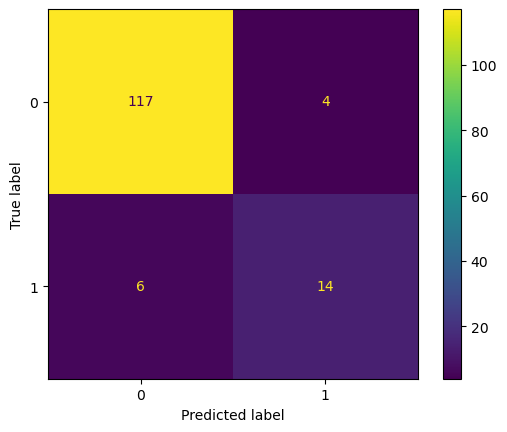

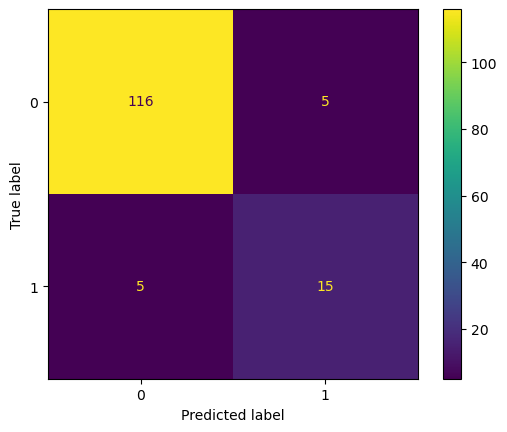

In [33]:
ConfusionMatrixDisplay(confusion_matrix(y_test, gb_preds)).plot()
ConfusionMatrixDisplay(confusion_matrix(y_test, rf_preds)).plot()

- GB has fewer false positives (3 vs 6), meaning it’s more conservative in predicting positives
- RF has slightly fewer false negatives (5 vs 6), so it catches slightly more actual positives.
- There's not much in it here, but the higher train AUC of RF combined with this confusion matrix still leans towards RF possibly overfitting.


Confusion matrix for GradientBoosting:
[[117   4]
 [  6  14]]

Confusion matrix for RandomForest:
[[116   5]
 [  5  15]]


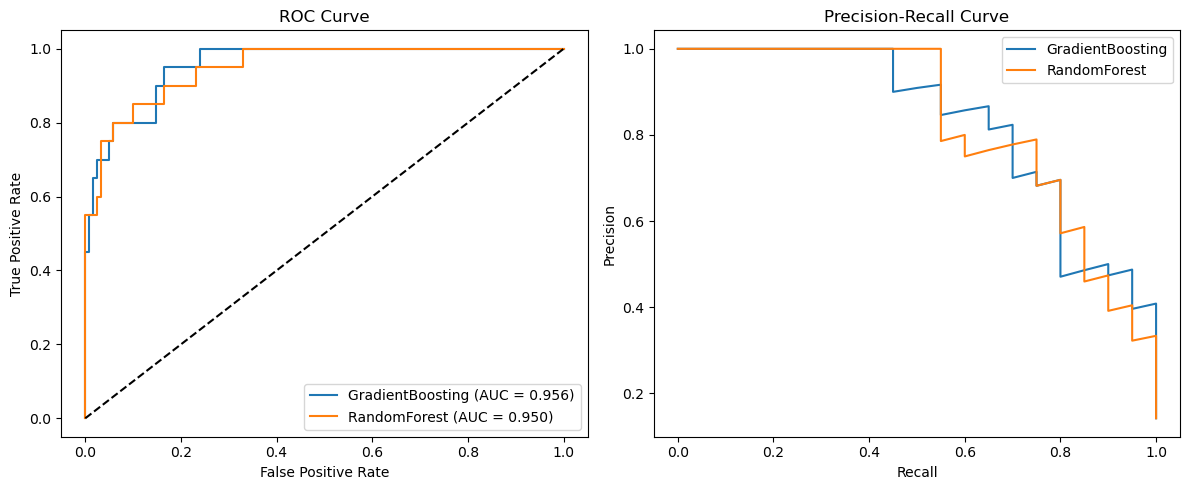

In [34]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # fallback for models without predict_proba
        dec = model.decision_function(X_test)
        y_prob = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion matrix for {model_name}:\n{cm}")
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    
    return fpr, tpr, roc_auc, precision, recall

# Evaluate both models
gb_fpr, gb_tpr, gb_auc, gb_precision, gb_recall = evaluate_model(gb_model, X_test, y_test, "GradientBoosting")
rf_fpr, rf_tpr, rf_auc, rf_precision, rf_recall = evaluate_model(rf_model, X_test, y_test, "RandomForest")

# Plot ROC curves
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(gb_fpr, gb_tpr, label=f'GradientBoosting (AUC = {gb_auc:.3f})')
plt.plot(rf_fpr, rf_tpr, label=f'RandomForest (AUC = {rf_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Plot Precision-Recall curves
plt.subplot(1, 2, 2)
plt.plot(gb_recall, gb_precision, label='GradientBoosting')
plt.plot(rf_recall, rf_precision, label='RandomForest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()


- Both models reach a true positive rate of 1 around a false positive rate of 0.35, with similar patterns.
- Overall, GradientBoosting offers a better precision-recall tradeoff at most thresholds.

Final Decision:
- Although RandomForest shows a very high train AUC (likely overfitting), its test performance is roughly on par with GradientBoosting.
- GradientBoosting’s slightly better precision at higher recall rates and fewer false positives indicate it might generalise a bit better on unseen data.
- The differences are subtle, but given GradientBoosting’s more moderate train AUC and precision-recall edge, it is a strong candidate to move forward with for further parameter tuning and testing.